#Classical Sampling Techniques

## Importing Libraries

In [1]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [3]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [4]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [7]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

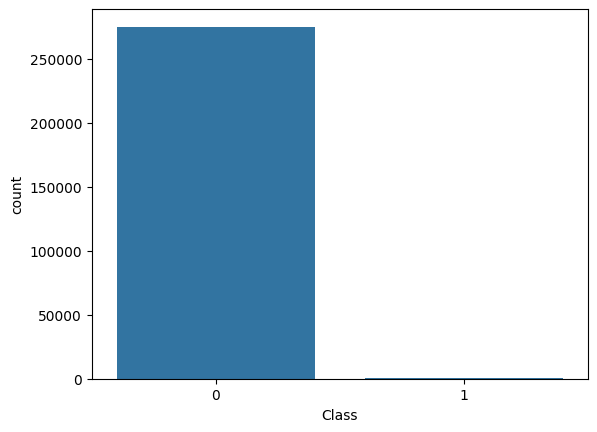

In [8]:
sns.countplot(data=df,x='Class')

In [9]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


<Axes: xlabel='Amount', ylabel='Density'>

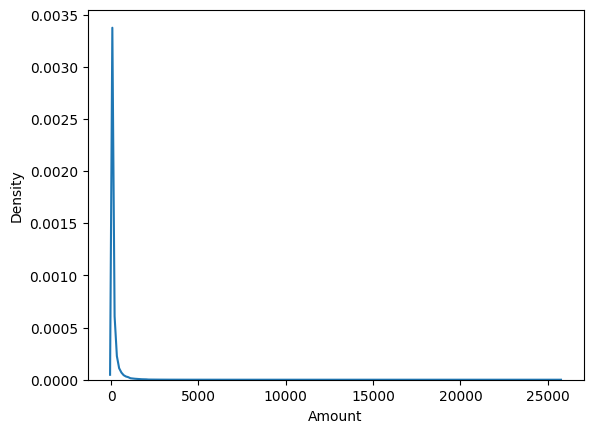

In [10]:
sns.kdeplot(df['Amount'])

<Axes: xlabel='Amount', ylabel='Density'>

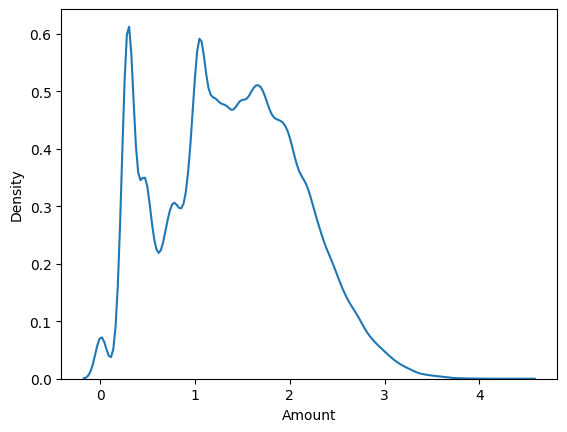

In [11]:
df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))
sns.kdeplot(df['Amount'])

## Creating a sub sample

What - create a[](http://) df with equal number of fraud and non fraud samples  
Why - Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the target. By having an imbalance dataframe we are not able to see the true correlations between the class and features

In [12]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

subsample = pd.concat([fraud_df, non_fraud_df])
new_df = subsample.sample(frac=1, random_state=42)

### Correlation

In [13]:
corr = df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

In [14]:
corr = new_df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

Negative Correlations: V17, V14, V12 and V10 are negatively correlated.  
Positive Correlations: V2, V4, V11 are positively correlated.

Note-Used chatgpt to understand the correlations. As the features are  anonymised it was difficult to conclude and get relationship and dependency on eachother.

In [15]:
# Calculate absolute correlation matrix (optional: choose df or new_df)
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicates and self-correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set threshold
threshold = 0.9

# Find feature pairs with high correlation
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.columns
                   if (upper.loc[col1, col2] > threshold)]

# Display results
print("Highly Correlated Feature Pairs (|r| > 0.9):")
for f1, f2, corr_value in high_corr_pairs:
    print(f"{f1} ↔ {f2}: r = {corr_value:.2f}")

Highly Correlated Feature Pairs (|r| > 0.9):
V11 ↔ V12: r = 0.90
V16 ↔ V17: r = 0.95
V17 ↔ V18: r = 0.94


Reference-https://data36.com/correlation-definition-calculation-corr-pandas/

### TSNE

In [16]:
from sklearn.manifold import TSNE
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

In [17]:
fig=px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=y)
fig.show()

Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately

Reference- https://www.geeksforgeeks.org/machine-learning/difference-between-pca-vs-t-sne/

Note-ChatGPT was used to help understand the results using WebSearch Feature.

## Scaling

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

## SMOTE, ADASYN & Borderline‑SMOTE

In [20]:
# Imports (add LightGBM)
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score

# -----------------------------
# Baseline 1: SMOTE + LightGBM
# -----------------------------
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

clf_smote = LGBMClassifier(
    objective="binary",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
clf_smote.fit(X_smote, y_smote)

y_pred_smote = clf_smote.predict(X_test)
y_scores_smote = clf_smote.predict_proba(X_test)[:, 1]

print("SMOTE + LightGBM results")
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))

roc_auc_smote = roc_auc_score(y_test, y_scores_smote)
pr_auc_smote  = average_precision_score(y_test, y_scores_smote)
print(f"SMOTE AUC-ROC: {roc_auc_smote:.3f}")
print(f"SMOTE AUC-PR : {pr_auc_smote:.3f}\n")

# -------------------------------------------
# Baseline 2: Borderline-SMOTE (borderline-1)
#            + LightGBM
# -------------------------------------------
border_smote = BorderlineSMOTE(random_state=42, kind='borderline-1')  # keep your original setting
X_bl, y_bl = border_smote.fit_resample(X_train, y_train)

clf_bl = LGBMClassifier(
    objective="binary",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
clf_bl.fit(X_bl, y_bl)

y_pred_bl = clf_bl.predict(X_test)
y_scores_bl = clf_bl.predict_proba(X_test)[:, 1]

print("Borderline-SMOTE + LightGBM results")
print(confusion_matrix(y_test, y_pred_bl))
print(classification_report(y_test, y_pred_bl))

roc_auc_bl = roc_auc_score(y_test, y_scores_bl)
pr_auc_bl  = average_precision_score(y_test, y_scores_bl)
print(f"Borderline-SMOTE AUC-ROC: {roc_auc_bl:.3f}")
print(f"Borderline-SMOTE AUC-PR : {pr_auc_bl:.3f}\n")

# -----------------------------
# Baseline 3: ADASYN + LightGBM
# -----------------------------
ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(X_train, y_train)

clf_ada = LGBMClassifier(
    objective="binary",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
clf_ada.fit(X_ada, y_ada)

y_pred_ada = clf_ada.predict(X_test)
y_scores_ada = clf_ada.predict_proba(X_test)[:, 1]

print("ADASYN + LightGBM results")
print(confusion_matrix(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))

roc_auc_ada = roc_auc_score(y_test, y_scores_ada)
pr_auc_ada  = average_precision_score(y_test, y_scores_ada)
print(f"ADASYN AUC-ROC: {roc_auc_ada:.3f}")
print(f"ADASYN AUC-PR : {pr_auc_ada:.3f}")


[LightGBM] [Info] Number of positive: 220152, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 440304, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



SMOTE + LightGBM results
[[55006    32]
 [   13    82]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.72      0.86      0.78        95

    accuracy                           1.00     55133
   macro avg       0.86      0.93      0.89     55133
weighted avg       1.00      1.00      1.00     55133

SMOTE AUC-ROC: 0.969
SMOTE AUC-PR : 0.849

[LightGBM] [Info] Number of positive: 220152, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 440304, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



Borderline-SMOTE + LightGBM results
[[55024    14]
 [   16    79]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.85      0.83      0.84        95

    accuracy                           1.00     55133
   macro avg       0.92      0.92      0.92     55133
weighted avg       1.00      1.00      1.00     55133

Borderline-SMOTE AUC-ROC: 0.969
Borderline-SMOTE AUC-PR : 0.853

[LightGBM] [Info] Number of positive: 220184, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 440336, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500036 -> initscore=0.000145
[LightGBM] [Info] Start training from score 0.000145


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



ADASYN + LightGBM results
[[54999    39]
 [   14    81]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.68      0.85      0.75        95

    accuracy                           1.00     55133
   macro avg       0.84      0.93      0.88     55133
weighted avg       1.00      1.00      1.00     55133

ADASYN AUC-ROC: 0.969
ADASYN AUC-PR : 0.835


Interpretation

All three resampling methods + LightGBM performed very strongly overall (accuracy ≈ 100%, AUC-ROC ≈ 0.97).

Borderline-SMOTE gave the best balance between precision and recall on the minority class → highest F1 (0.84) and best AUC-PR (0.853).

SMOTE slightly favors recall (0.86) at the cost of precision (0.72), which could be useful if missing positives is costly.

ADASYN also boosts recall (0.85) but has weaker precision (0.68), leading to the lowest F1 and AUC-PR of the three.

Borderline-SMOTE + LightGBM is the strongest baseline, offering the best trade-off between capturing minority cases and keeping false positives low.

SMOTE is a good alternative when recall is more critical.

ADASYN underperforms here, suggesting its synthetic samples may add noise in this dataset.

Note-ChatGPT was used to help understand the results for all 3 different oversampling methods.

Reference- [Generative Adversarial Networks-Based Novel Approach for Fraud Detection for the European Cardholders 2013 Dataset](https://doi.org/10.1109/ACCESS.2023.3320072), [A Comparison Study of Credit Card Fraud Detection: Supervised versus Unsupervised](https://arxiv.org/abs/1904.10604)